# Patching the Cross Validation Performance of Various Feature Sets v3

The `provean_score` and `ddG` values were used without any threshold. This results in creating undesirable rules for these single feature values.
Here we use either a fixed threshold value or an adaptive threshold value for these single features.


## i'll add all metrics now

In [1]:
import os

os.chdir("../")

In [2]:
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import BaseEstimator

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import copy

from tqdm.notebook import tqdm

from src.helpers.helpers_predator.common import load_predator

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [3]:
PREDATOR_PATH = "PredatorModels/PredatorModel_2021-10-24/04f37897/predator.pkl"

In [4]:
predator = load_predator(PREDATOR_PATH)

Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


2021-12-28 14:37:03 | INFO     | src.helpers.helpers_predator.common | Predator object PredatorModels/PredatorModel_2021-10-24/04f37897/predator.pkl is loaded successfully.


Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


In [5]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [6]:
Xs_ddG = copy.deepcopy(predator.data_materials["Xs_ddG"])
Xs_provean = copy.deepcopy(predator.data_materials["Xs_provean"])
ys = copy.deepcopy(predator.data_materials["ys"])

In [7]:
def get_decision_tree_threshold_val(clf_param):
    text_representation = tree.export_text(clf_param)
    thr_val = float(text_representation.split("\n")[0].split()[-1])
    return thr_val

In [8]:
# class BaselineThresholdClassifier(BaseEstimator):
#     def __init__(self, threshold, classify_func):
#         self.threshold = threshold
#         self.classify_func = classify_func
#
#     def fit(self, X, y=None):
#         pass
#
#     def predict(self, X):
#         return np.array([self.classify_func(val) for val in X["Final_ddG"]])


# class BaselineDeltaDeltaGAdaptiveClassifier(DecisionTreeClassifier):
#     """
#     Uses the threshold value that separates the data instances best.
#     """
#
#     MAX_DEPTH = 1
#
#     def __init__(self, max_depth=MAX_DEPTH):
#         self.max_depth = max_depth
#         super().__init__(max_depth=max_depth)


In [9]:
class BaselineProveanClassifier(BaseEstimator):
    """
    Prediction: "Deleterious" if the score is less than or equal to a predefined threshold.
    For our classification:
        if Provean <= thr:
            deleterious (disrupting, class 0)
        else:
            non deleterious (increasing or no effect, class 1)
    """
    PROVEAN_DEFAULT_THRESHOLD = -2.5
    FEATURE_NAME = "Provean_score"

    def __init__(self, feature_name=FEATURE_NAME, threshold=PROVEAN_DEFAULT_THRESHOLD):
        self.feature_name = feature_name
        self.threshold = threshold

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.array([self.apply_threshold(val) for val in X[self.feature_name]])

    def apply_threshold(self, val):
        if val <= self.threshold:
            return 0  # class 0: disrupting

        else:
            return 1  # class 1: increasing + no effect

In [10]:
class BaselineDeltaDeltaGClassifier(BaseEstimator):
    """
    todo: could not find it explicitly, re check
    """
    DELTA_DELTA_G_DEFAULT_THRESHOLD = 0
    FEATURE_NAME = "Final_ddG"

    def __init__(self, feature_name=FEATURE_NAME, threshold=DELTA_DELTA_G_DEFAULT_THRESHOLD):
        self.feature_name = feature_name
        self.threshold = threshold

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.array([self.apply_threshold(val) for val in X[self.feature_name]])

    def apply_threshold(self, val):
        if val < self.threshold:
            return 0  # class 0: disrupting

        else:
            return 1  # class 1: increasing + no effect

In [11]:
from sklearn.tree import DecisionTreeClassifier

class BaselineAdaptiveThresholdClassifier(DecisionTreeClassifier):
    """
    Uses the threshold value that separates the data instances best.
    """

    MAX_DEPTH = 1

    def __init__(self, max_depth=MAX_DEPTH):
        self.max_depth = max_depth
        super().__init__(max_depth=max_depth)

In [12]:
foo = DecisionTreeClassifier()
foo.criterion

'gini'

In [13]:
clf = BaselineAdaptiveThresholdClassifier()
clf.fit(Xs_ddG[0][:132], ys[0][:132])
clf.predict(Xs_ddG[0][132:])

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [14]:
balanced_accuracy_score(ys[0][132:], clf.predict(Xs_ddG[0][132:]))

0.699134199134199

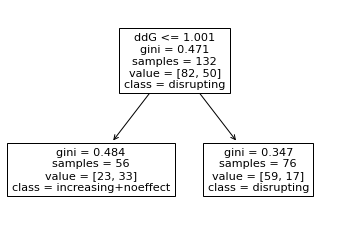

In [15]:
fig = plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [16]:
get_decision_tree_threshold_val(clf)

1.0

In [17]:
X_ddG_sample = Xs_ddG[0]
X_provean_sample = Xs_provean[0]
y_sample = ys[0]

In [18]:
clf = BaselineProveanClassifier()
clf.fit(None, None)
pred = clf.predict(X_provean_sample)
pd.DataFrame(pred).value_counts()

0    144
1     20
dtype: int64

In [19]:
clf = BaselineDeltaDeltaGClassifier()
clf.fit(None, None)
pred = clf.predict(X_ddG_sample)
pd.DataFrame(pred).value_counts()

1    149
0     15
dtype: int64

In [20]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X_ddG_sample, y_sample)
print(clf.tree_.max_depth)

1


In [21]:
clf.classes_

array([0, 1], dtype=int64)

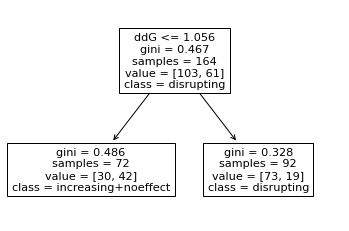

In [22]:
plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [23]:
get_decision_tree_threshold_val(clf)

1.06

5


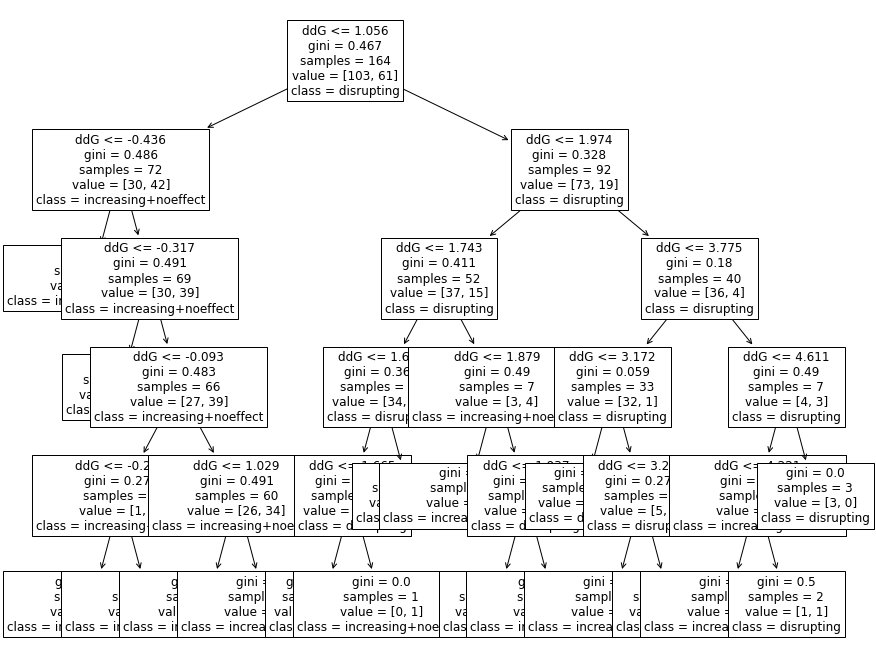

In [24]:
clf_deeper = DecisionTreeClassifier(max_depth=5)
clf_deeper = clf_deeper.fit(X_ddG_sample, y_sample)
print(clf_deeper.tree_.max_depth)
plt.figure(figsize=(14, 12))
tree.plot_tree(clf_deeper, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"], fontsize=12);

In [25]:
from src.helpers.helpers_predator.evaluation import cross_val_score_feature_comparison

In [26]:
cross_val_score_feature_comparison(
    X=X_provean_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineProveanClassifier()
)

0.6251

In [27]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineDeltaDeltaGClassifier()
)

0.4416

In [28]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineAdaptiveThresholdClassifier()
)

0.6672

In [29]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

mcc = make_scorer(matthews_corrcoef)

EVAL_METRICS_DICT = {
    "F1": "f1",
    "BALANCED_ACCURACY": "balanced_accuracy",
    "ACCURACY": "accuracy",
    "F1_MACRO": "f1_macro",
    "F1_MICRO": "f1_micro",
    "PRECISION": "precision",
    "RECALL": "recall",
    "ROC_AUC": "roc_auc",
    "PRECISION_MACRO": "precision_macro",
    "PRECISION_MICRO": "precision_micro",
    # Custom metrics
    "MCC": mcc,
}

In [30]:
for metric_name, metric in EVAL_METRICS_DICT.items():
    print(f"{metric_name} - {metric}")

F1 - f1
BALANCED_ACCURACY - balanced_accuracy
ACCURACY - accuracy
F1_MACRO - f1_macro
F1_MICRO - f1_micro
PRECISION - precision
RECALL - recall
ROC_AUC - roc_auc
PRECISION_MACRO - precision_macro
PRECISION_MICRO - precision_micro
MCC - make_scorer(matthews_corrcoef)


In [31]:
N_JOBS = -2
N_REPEAT = 5

In [32]:
from collections import defaultdict

In [33]:
# Fixed thresholds only, but more evaluation metrics.
def benchmark_single_features(data_materials):
    Xs_ddG = copy.deepcopy(data_materials["Xs_ddG"])
    Xs_provean = copy.deepcopy(data_materials["Xs_provean"])
    ys = copy.deepcopy(data_materials["ys"])

    ddg_scoring_metrics = defaultdict(list)
    provean_scoring_metrics = defaultdict(list)

    for X_ddg, X_provean, y in tqdm(zip(Xs_ddG, Xs_provean, ys), total=len(ys)):

        for metric_name, metric in EVAL_METRICS_DICT.items():

            # ddG scoring values
            ddg_scores = cross_val_score_feature_comparison(
                X=X_ddg,
                y=y,
                scoring=metric,
                n_repeats=N_REPEAT,
                n_jobs=N_JOBS,
                clf=BaselineDeltaDeltaGClassifier()
            )

            ddg_scoring_metrics[metric_name].append(ddg_scores)

            # Provean scoring values
            provean_scores = cross_val_score_feature_comparison(
                X=X_provean,
                y=y,
                scoring=metric,
                n_repeats=N_REPEAT,
                n_jobs=N_JOBS,
                clf=BaselineProveanClassifier()
            )

            provean_scoring_metrics[metric_name].append(provean_scores)

    return ddg_scoring_metrics, provean_scoring_metrics


In [34]:
obtained_ddg_scoring_metrics, obtained_provean_scoring_metrics = benchmark_single_features(predator.data_materials)

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
obtained_ddg_scoring_metrics.keys()

dict_keys(['F1', 'BALANCED_ACCURACY', 'ACCURACY', 'F1_MACRO', 'F1_MICRO', 'PRECISION', 'RECALL', 'ROC_AUC', 'PRECISION_MACRO', 'PRECISION_MICRO', 'MCC'])

In [36]:
obtained_provean_scoring_metrics.keys()

dict_keys(['F1', 'BALANCED_ACCURACY', 'ACCURACY', 'F1_MACRO', 'F1_MICRO', 'PRECISION', 'RECALL', 'ROC_AUC', 'PRECISION_MACRO', 'PRECISION_MICRO', 'MCC'])

In [37]:
obtained_ddg_scoring_metrics_data = pd.DataFrame(obtained_ddg_scoring_metrics)
obtained_ddg_scoring_metrics_data["FEATURES"] = "$\Delta\Delta$G score only (Fixed threshold)"
obtained_ddg_scoring_metrics_data = obtained_ddg_scoring_metrics_data.melt(var_name="METRIC", value_name="SCORE", id_vars="FEATURES")

In [38]:
obtained_provean_scoring_metrics_data = pd.DataFrame(obtained_provean_scoring_metrics)
obtained_provean_scoring_metrics_data["FEATURES"] = "Provean score only (Fixed threshold)"
obtained_provean_scoring_metrics_data = obtained_provean_scoring_metrics_data.melt(var_name="METRIC", value_name="SCORE", id_vars="FEATURES")

In [39]:
obtained_ddg_scoring_metrics_data

,FEATURES,METRIC,SCORE
0,$\Delta\Delta$G score only (Fixed threshold),F1,0.4836
1,$\Delta\Delta$G score only (Fixed threshold),F1,0.4889
2,$\Delta\Delta$G score only (Fixed threshold),F1,0.4289
3,$\Delta\Delta$G score only (Fixed threshold),F1,0.4147
4,$\Delta\Delta$G score only (Fixed threshold),F1,0.4376
...,...,...,...
545,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.2093
546,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.1002
547,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.2062
548,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.2542


In [40]:
obtained_provean_scoring_metrics_data

,FEATURES,METRIC,SCORE
0,Provean score only (Fixed threshold),F1,0.3909
1,Provean score only (Fixed threshold),F1,0.3749
2,Provean score only (Fixed threshold),F1,0.4648
3,Provean score only (Fixed threshold),F1,0.4764
4,Provean score only (Fixed threshold),F1,0.4138
...,...,...,...
545,Provean score only (Fixed threshold),MCC,0.3754
546,Provean score only (Fixed threshold),MCC,0.3453
547,Provean score only (Fixed threshold),MCC,0.4021
548,Provean score only (Fixed threshold),MCC,0.3999


In [41]:
def change_shap_top_names(feature_name: str):
    mapping = {
        'Provean': "Provean score only",
        '$\Delta\Delta$G': "$\Delta\Delta$G score only",
        'All Columns': "Predator_all",
        'SHAP Columns (5)': "Predator_SHAP_Top_5",
        'SHAP Columns (10)': "Predator",
        'SHAP Columns (20)': "Predator_SHAP_Top_20",
        'SHAP Columns (30)': "Predator_SHAP_Top_30",
        'SHAP Columns (40)': "Predator_SHAP_Top_40",
    }

    return mapping[feature_name]

In [42]:
scoring_metrics_data_melted = predator.eval_metrics.scoring_metrics_data_melted.copy()
scoring_metrics_data_melted["FEATURES"] = scoring_metrics_data_melted["FEATURES"].apply(lambda x: change_shap_top_names(x))
# scoring_metrics_data_melted_balanced_accuracy = scoring_metrics_data_melted[
#     scoring_metrics_data_melted["METRIC"].isin(
#         ["BALANCED_ACCURACY", "F1"]
#     )
# ].copy()
scoring_metrics_data_melted.drop(["X_NAME", "EXPERIMENT_NO"], axis="columns", inplace=True)
scoring_metrics_data_melted

,FEATURES,METRIC,SCORE
0,Provean score only,F1,0.3957
1,$\Delta\Delta$G score only,F1,0.2854
2,Predator_all,F1,0.4969
3,Predator_SHAP_Top_5,F1,0.5704
4,Predator,F1,0.6410
...,...,...,...
83,Predator_SHAP_Top_5,MCC,0.3563
84,Predator,MCC,0.3063
85,Predator_SHAP_Top_20,MCC,0.3194
86,Predator_SHAP_Top_30,MCC,0.2667


In [43]:
scoring_metrics_data_melted_predators = scoring_metrics_data_melted[
    scoring_metrics_data_melted["FEATURES"].apply(lambda x: "predator" in x.lower())
].copy()

In [45]:
obtained_ddg_scoring_metrics_data

,FEATURES,METRIC,SCORE
0,$\Delta\Delta$G score only (Fixed threshold),F1,0.4836
1,$\Delta\Delta$G score only (Fixed threshold),F1,0.4889
2,$\Delta\Delta$G score only (Fixed threshold),F1,0.4289
3,$\Delta\Delta$G score only (Fixed threshold),F1,0.4147
4,$\Delta\Delta$G score only (Fixed threshold),F1,0.4376
...,...,...,...
545,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.2093
546,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.1002
547,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.2062
548,$\Delta\Delta$G score only (Fixed threshold),MCC,-0.2542


In [47]:
# obtained_ddg_scoring_metrics_data
# obtained_provean_scoring_metrics_data

In [53]:
scoring_metrics_data_melted_predator_vs_single_features = scoring_metrics_data_melted[
    scoring_metrics_data_melted["FEATURES"] == "Predator"
].copy()

scoring_metrics_data_melted_predator_vs_single_features = pd.concat(
    [
        scoring_metrics_data_melted_predator_vs_single_features,
        obtained_ddg_scoring_metrics_data,
        obtained_provean_scoring_metrics_data,
    ], axis="rows"
)

In [54]:
scoring_metrics_data_melted_predator_vs_single_features

,FEATURES,METRIC,SCORE
4,Predator,F1,0.6410
12,Predator,BALANCED_ACCURACY,0.7276
20,Predator,ACCURACY,0.7589
28,Predator,F1_MACRO,0.7156
36,Predator,F1_MICRO,0.7653
...,...,...,...
545,Provean score only (Fixed threshold),MCC,0.3754
546,Provean score only (Fixed threshold),MCC,0.3453
547,Provean score only (Fixed threshold),MCC,0.4021
548,Provean score only (Fixed threshold),MCC,0.3999


In [56]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

In [57]:
from pandas.api.types import CategoricalDtype

In [58]:
legend_order = [
    'Provean score only',
    'Provean score only (Fixed threshold)',
    'Provean score only (Adaptive threshold)',
    '$\Delta\Delta$G score only',
    '$\Delta\Delta$G score only (Fixed threshold)',
    '$\Delta\Delta$G score only (Adaptive threshold)',
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order = CategoricalDtype(
    legend_order, ordered=True
)
cat_size_order

CategoricalDtype(categories=['Provean score only', 'Provean score only (Fixed threshold)',
                  'Provean score only (Adaptive threshold)',
                  '$\Delta\Delta$G score only',
                  '$\Delta\Delta$G score only (Fixed threshold)',
                  '$\Delta\Delta$G score only (Adaptive threshold)',
                  'Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [59]:
legend_order_predator = [
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order_predator = CategoricalDtype(
    legend_order_predator, ordered=True
)
cat_size_order_predator

CategoricalDtype(categories=['Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [60]:
legend_order_others = [
    'Provean score only (Fixed threshold)',
    '$\Delta\Delta$G score only (Fixed threshold)',
    'Predator',
]

cat_size_order_others = CategoricalDtype(
    legend_order_others, ordered=True
)
cat_size_order_others

CategoricalDtype(categories=['Provean score only (Fixed threshold)',
                  '$\Delta\Delta$G score only (Fixed threshold)', 'Predator'],
, ordered=True)

In [61]:
scoring_metrics_data_melted_predators["FEATURES"] = scoring_metrics_data_melted_predators["FEATURES"].astype(cat_size_order_predator)
scoring_metrics_data_melted_predator_vs_single_features["FEATURES"] = scoring_metrics_data_melted_predator_vs_single_features["FEATURES"].astype(cat_size_order_others)

In [55]:
# concated_scoring_data["FEATURES"] = concated_scoring_data["FEATURES"].astype(cat_size_order)
# concated_scoring_data

,FEATURES,METRIC,SCORE
0,Provean score only,F1,0.3957
1,$\Delta\Delta$G score only,F1,0.2854
2,Predator_all,F1,0.4969
3,Predator_SHAP_Top_5,F1,0.5704
4,Predator,F1,0.6410
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.7098
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.5749
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6622
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6175


In [57]:
# concated_scoring_data = concated_scoring_data.sort_values(["FEATURES"])

## 1. Predator versions with all evaluation metrics


In [62]:
scoring_metrics_data_melted_predators

,FEATURES,METRIC,SCORE
2,Predator_all,F1,0.4969
3,Predator_SHAP_Top_5,F1,0.5704
4,Predator,F1,0.6410
5,Predator_SHAP_Top_20,F1,0.5965
6,Predator_SHAP_Top_30,F1,0.5667
...,...,...,...
83,Predator_SHAP_Top_5,MCC,0.3563
84,Predator,MCC,0.3063
85,Predator_SHAP_Top_20,MCC,0.3194
86,Predator_SHAP_Top_30,MCC,0.2667


In [64]:
scoring_metrics_data_melted_predators_sorted = scoring_metrics_data_melted_predators.copy()
scoring_metrics_data_melted_predators_sorted = scoring_metrics_data_melted_predators_sorted.sort_values(["FEATURES", "METRIC"], ascending=[True, False])

## 2. Predator vs ddG vs Provean


In [65]:
scoring_metrics_data_melted_predator_vs_single_features_sorted = scoring_metrics_data_melted_predator_vs_single_features.copy()
scoring_metrics_data_melted_predator_vs_single_features_sorted = scoring_metrics_data_melted_predator_vs_single_features_sorted.sort_values(["FEATURES", "METRIC"], ascending=[True, False])

## Plotting

In [66]:
from datetime import datetime

In [67]:
import os.path as op

In [69]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


def plot_performance_comparison_results(
        scoring_metrics_data_melted,
        metrics,
        filename,
        palette_param,
        figsize=(8, 7),
        export=False,
        overwrite=False,
        title=None
):
    # sns.set_theme(style="ticks", palette="pastel", font_scale=1.5)  # TODO: POSTER,uncommendLATER
    # sns.set_theme(style="ticks", font_scale=2)  ## palette="pastel"
    sns.set_theme(style="ticks", palette="Set3", font_scale=2)  ## palette="pastel"
    # sns.set_theme(style="white", font_scale=2)  ## palette="pastel"

    # colors_12 = [
    #     # provean
    #     "#F2F2AE",
    #     "#F2C900", # F2DE5C
    #     "#A6915F", # F2C900
    #     # ddG
    #     "#B7E1EE", # B9BFC4, 7FB3C2
    #     "#609BB1", # 609BB1, 24849D
    #     "#105B7A",  # FF616D
    #     # predators
    #     "#F0F1F1", # Predator All  # C6AAB6
    #     "#C6AAB6", # Predator 5  # AC7F93
    #     "#E81123", # Predator 10  # FF616D, F2ECDB, E81123
    #     "#AC7F93", # Predator 20
    #     "#965B77", # Predator 30
    #     "#823960", # Predator 40
    # ]
    # sns.set_palette(sns.color_palette(colors_12))


    # TODO: [later] plot size adjusting itself depending on input ↓
    # plt.figure(figsize=(3 * len(metrics), 7))
    plt.figure(figsize=figsize)
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features"
    # title_string_2 = fr"CV = 10, CV\_repeat = {self.n_repeats}, Experiment\_repeat = {self.n_experiment}"
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features"
    # title_string_2 = ""
    # title_string_1 = fr"Balanced\ Accuracy\ of\ Feature\ Sets"
    if title is None:
        title_string_1 = fr"Performance\ Comparison\ of\ Feature\ Sets"
    else:
        title_string_1 = title

    title_string_2 = ""
    # plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    # plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontweight='bold')
    plt.title(f"$\mathbf{{{title_string_1}}}$", fontweight='bold')

    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
    # noinspection SpellCheckingInspection

    if metrics is not None:
        scoring_metrics_data_melted_less_metrics = scoring_metrics_data_melted[
            scoring_metrics_data_melted['METRIC'].isin(metrics)
        ]
        scoring_metrics_data_plot = scoring_metrics_data_melted_less_metrics

    else:
        scoring_metrics_data_plot = scoring_metrics_data_melted

    # ax = sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_melted_less_metrics,
    #                  palette='Pastel1')  # bone, vlag, cividis, #03012d, light:#444452

    ax = sns.boxplot(
        x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_plot, saturation=1, palette=palette_param
    )
    # palette='deep')  # bone, vlag, cividis, #03012d, light:#444452

    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='#ababab', lw=1)
    plt.xticks(ha='right', rotation=45)
    # legend = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), edgecolor="black") ############
    # legend.get_frame().set_alpha(None)
    ###################
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), framealpha=0)
    # plt.tight_layout()  # poster purpose
    # plt.savefig('foo2.png')  # poster purpose


    #     plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.ylabel('Balanced Accuracy', fontsize=16, fontweight='bold')
    # plt.ylabel('Balanced Accuracy')
    plt.ylabel('Score')
    #     plt.xlabel('Balanced Accuracy', fontsize=24, fontweight='bold')

    # plt.xticks([])
    plt.xlabel('Metrics', fontsize=24, fontweight='bold')

    if export:
        file_date = datetime.today().strftime('%Y-%m-%d')
        if filename is None:
            filename = f"figures/performance_comparison_selected_features_{file_date}.pdf"
        else:
            filename = f"figures/{filename}_{file_date}.pdf"

        if op.isfile(filename) and not overwrite:
            raise FileExistsError

        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot {filename} is exported.")

    plt.show()
    # sns.despine(offset=10, trim=True)


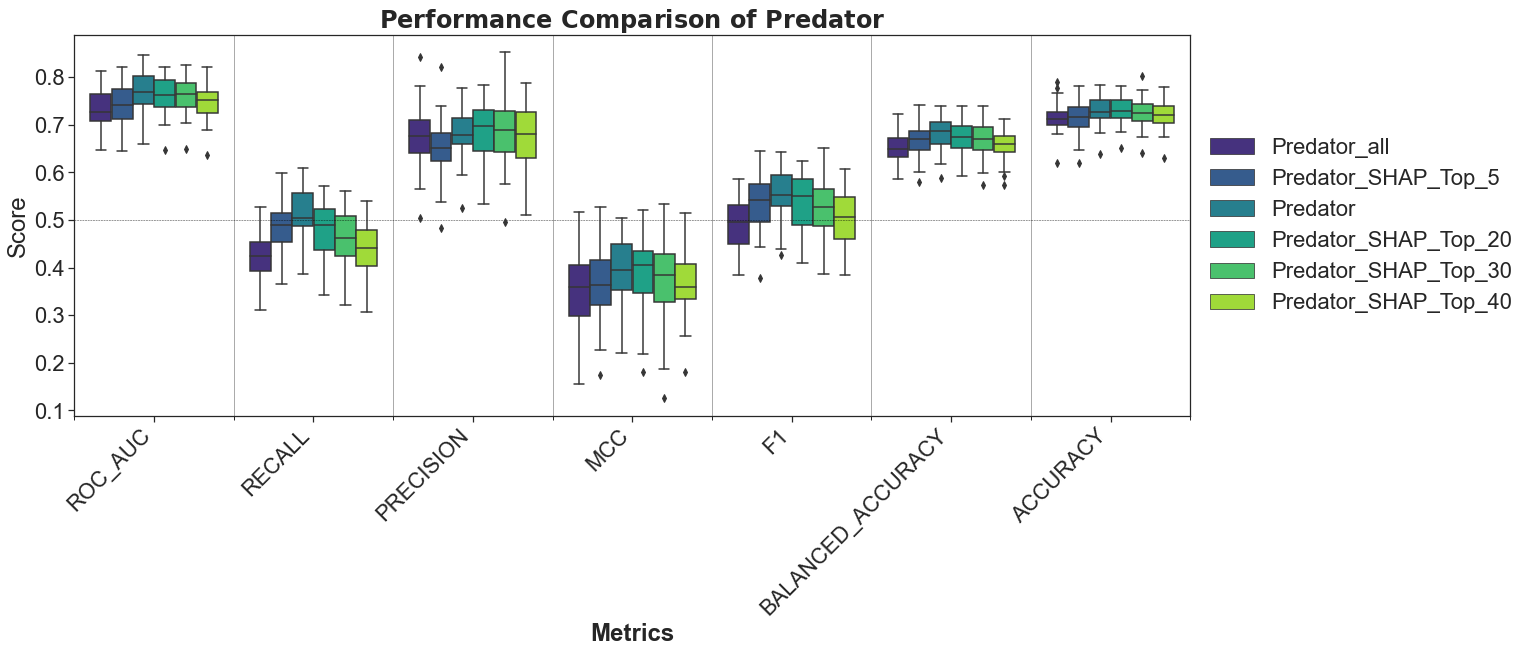

In [80]:
# metrics = ["BALANCED_ACCURACY", "F1"]
metrics = [
    metric for metric in list(
        scoring_metrics_data_melted_predator_vs_single_features_sorted["METRIC"].unique()
    ) if metric not in [
        "PRECISION_MICRO", "PRECISION_MACRO", "F1_MICRO", "F1_MACRO"
    ]
]
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predators_sorted,
    metrics=metrics,
    filename="supplementary_predator_all_metrics",
    palette_param="viridis",
    figsize=(20, 7),
    export=False,
    overwrite=True,
    title=r"Performance\ Comparison\ of\ Predator"
)

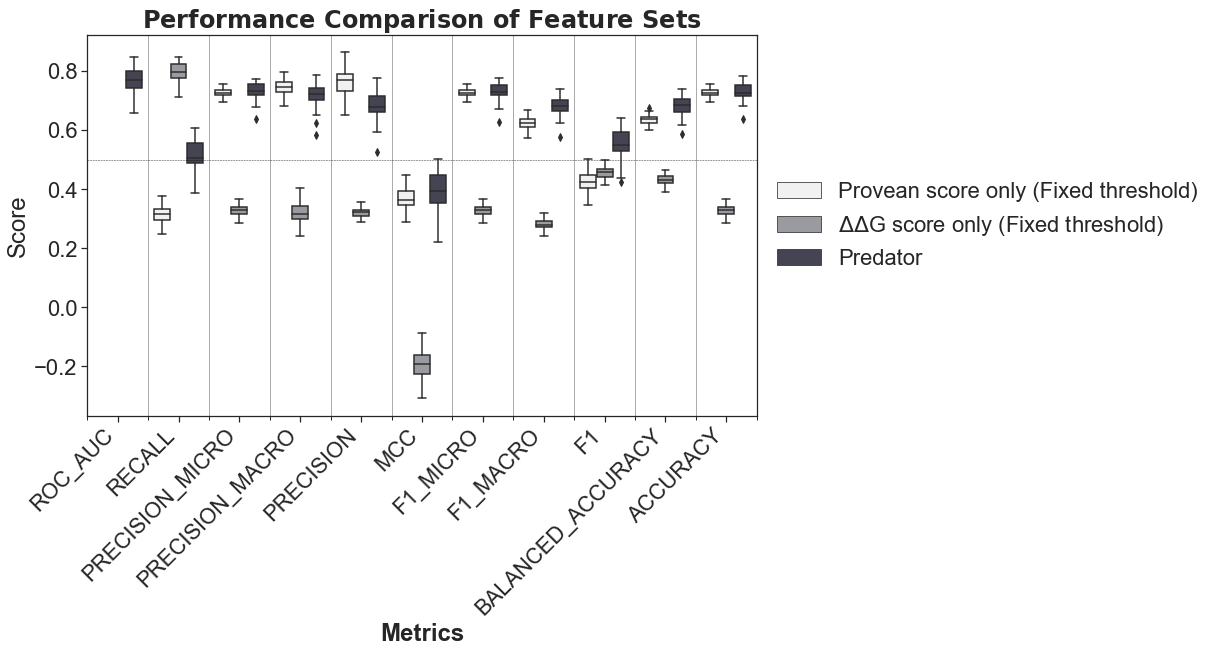

In [75]:
metrics = list(scoring_metrics_data_melted_predator_vs_single_features_sorted["METRIC"].unique())
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predator_vs_single_features_sorted,
    metrics=metrics,
    filename="performance_comparison_provean-ddg-predator",
    palette_param="light:#444452",
    figsize=(12, 7),
    export=False,
    overwrite=False
)

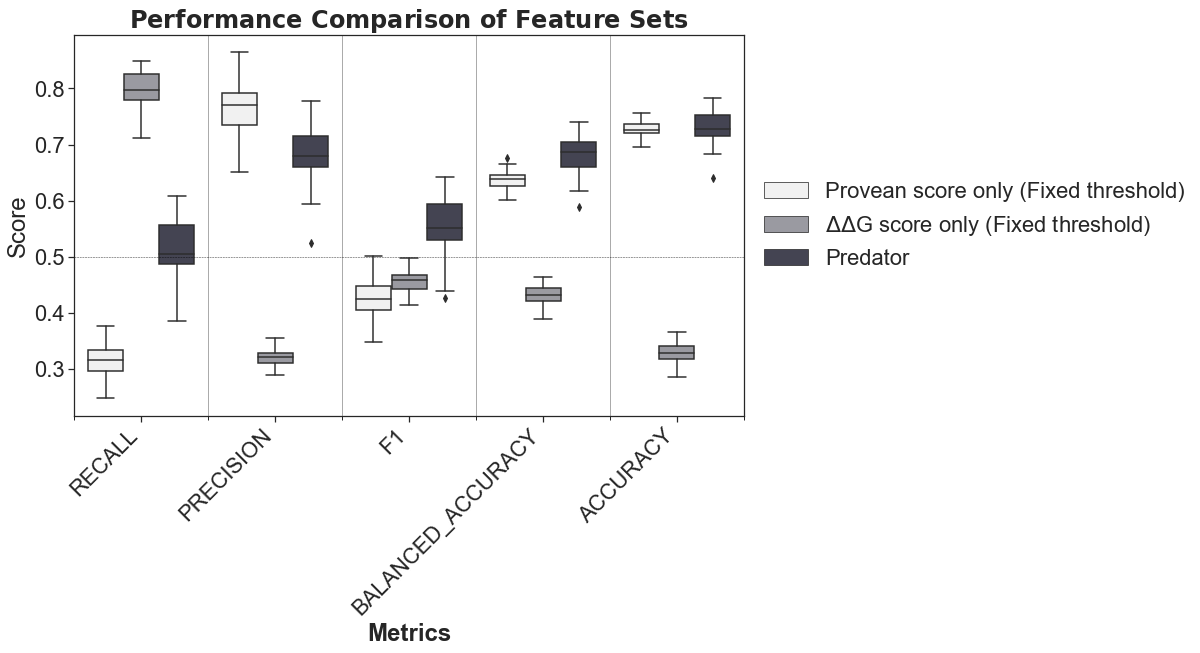

In [77]:
metrics = [
    metric for metric in list(
        scoring_metrics_data_melted_predator_vs_single_features_sorted["METRIC"].unique()
    ) if metric not in [
        "MCC", "ROC_AUC", "PRECISION_MICRO", "PRECISION_MACRO", "F1_MICRO", "F1_MACRO"
    ]
]
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predator_vs_single_features_sorted,
    metrics=metrics,
    filename="performance_comparison_provean-ddg-predator",
    palette_param="light:#444452",
    figsize=(12, 7),
    export=False,
    overwrite=False
)

In [ ]:
"""
default' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
"""

# Shap

In [81]:
import shap

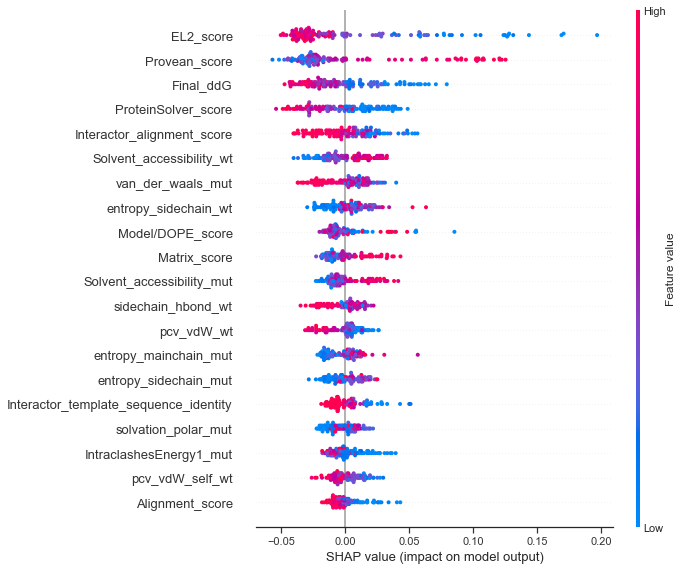

In [82]:
shap.summary_plot(
    predator.shap_feature_selector.shap_values_train_list[3][1],
    predator.data_materials["Xs_train"][3]
)

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [124]:
predator.data_materials["train_data_processed"]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0,P84243,Q94A,Q9UER7-3,1.0000,0.948980,1.0000,0.306767,-0.387860,0.995137,...,309.0,21.27130,20.85060,32.4886,32.4886,1159.700,952.745,2112.450,3.00752,4.27950
736,0,Q96QK1,L589D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.178790,0.803401,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
737,0,Q96QK1,L589D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.178790,0.803401,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
738,0,P23297,F72L,P25815,0.6778,0.664382,0.5222,0.517348,1.742750,0.889921,...,188.0,26.74010,27.29430,17.1488,16.8699,667.920,288.795,956.720,3.26388,3.30643


In [98]:
print(len(predator.data_materials["sampled_train_data_list"]))
print(len(predator.data_materials["Xs"]))

50
50


In [104]:
predator.random_seeds[17]

3906

In [105]:
def recover_sampled_train_data(data, random_seed):
    data_shuffled = data.sample(frac=1, random_state=random_seed).reset_index(drop=True).copy()
    return data_shuffled

In [113]:
recovered_sampled_datasets = []
for i in range(predator.n_experiment):
    recovered_sampled_datasets.append(
        recover_sampled_train_data(
            data=predator.data_materials["sampled_train_data_list"][i],
            random_seed=predator.random_seeds[i]
        )
    )

### check *dataframe 17*

In [115]:
recovered_sampled_datasets[17]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q96F10,R126C,P21673,0.4556,0.479980,1.0000,0.994152,-0.402073,0.204139,...,339.0,58.49900,57.29130,44.29030,44.29030,1726.210,723.565,2449.770,3.31886,3.02838
1,1,P84022,T330A,O95405,0.9742,0.918665,1.0000,0.911111,0.538351,0.985070,...,235.0,50.98660,50.52340,6.17388,6.17388,765.595,235.955,1001.550,3.68334,5.14410
2,1,P63000,G12V,P52757-9,0.7031,0.717945,0.2877,0.248442,1.953510,0.999291,...,382.0,62.21390,63.30310,57.99190,57.99190,499.240,316.330,815.575,4.12981,2.31457
3,0,P40337,C162F,Q15369,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,...,244.0,29.53660,33.85950,21.50880,22.80890,505.680,179.230,684.910,3.20023,2.60679
4,0,Q9BV40,L51P,O15400,0.9815,0.530509,0.9833,0.922627,1.453490,0.547931,...,114.0,11.23150,15.65910,10.96010,10.96010,700.760,240.210,940.970,3.89396,4.53949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0,Q9HAU5,F1113E,Q92900,0.6064,0.340182,0.9809,0.975641,2.516480,-0.088466,...,257.0,106.34600,106.07900,103.78800,103.78800,0.000,0.000,0.000,3.43605,2.56962
160,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.46750,52.46750,427.775,194.715,622.495,3.35293,3.35293
161,0,Q9H269,R725E,Q96AX1,1.0000,0.292308,0.9663,0.964737,3.361550,-0.015867,...,689.0,11.53180,11.33020,155.41400,155.41400,288.615,244.200,532.815,2.56253,3.46260
162,0,Q8WXH0,P6883A,Q9UH99-3,0.8333,0.348263,0.8978,0.855388,1.490470,0.063946,...,215.0,2.18022,2.18201,52.39200,52.39200,373.020,188.565,561.590,4.12462,4.12462


In [116]:
predator.data_materials["Xs"][17]

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.4556,0.479980,1.0000,0.994152,-0.402073,0.204139,0.057368,1.391579,-0.546441,-5.809,...,339.0,58.49900,57.29130,44.29030,44.29030,1726.210,723.565,2449.770,3.31886,3.02838
1,0.9742,0.918665,1.0000,0.911111,0.538351,0.985070,0.395633,1.768714,-1.493130,-4.178,...,235.0,50.98660,50.52340,6.17388,6.17388,765.595,235.955,1001.550,3.68334,5.14410
2,0.7031,0.717945,0.2877,0.248442,1.953510,0.999291,0.978707,2.337643,-0.794557,-4.637,...,382.0,62.21390,63.30310,57.99190,57.99190,499.240,316.330,815.575,4.12981,2.31457
3,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,-9.979,...,244.0,29.53660,33.85950,21.50880,22.80890,505.680,179.230,684.910,3.20023,2.60679
4,0.9815,0.530509,0.9833,0.922627,1.453490,0.547931,0.301686,2.445530,-1.389070,-7.000,...,114.0,11.23150,15.65910,10.96010,10.96010,700.760,240.210,940.970,3.89396,4.53949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.6064,0.340182,0.9809,0.975641,2.516480,-0.088466,0.561741,1.144949,1.020840,-8.573,...,257.0,106.34600,106.07900,103.78800,103.78800,0.000,0.000,0.000,3.43605,2.56962
160,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,0.032483,-0.976256,-0.085671,-5.895,...,118.0,5.30636,3.79101,52.46750,52.46750,427.775,194.715,622.495,3.35293,3.35293
161,1.0000,0.292308,0.9663,0.964737,3.361550,-0.015867,0.104270,0.457039,-1.055320,-4.211,...,689.0,11.53180,11.33020,155.41400,155.41400,288.615,244.200,532.815,2.56253,3.46260
162,0.8333,0.348263,0.8978,0.855388,1.490470,0.063946,-0.065058,-1.328399,-0.057966,-7.597,...,215.0,2.18022,2.18201,52.39200,52.39200,373.020,188.565,561.590,4.12462,4.12462


In [117]:
predator.data_materials["prepared_dataframes"][17]

,Mutation_Effect_Label,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,0.4556,0.479980,1.0000,0.994152,-0.402073,0.204139,0.057368,1.391579,-0.546441,...,339.0,58.49900,57.29130,44.29030,44.29030,1726.210,723.565,2449.770,3.31886,3.02838
1,1,0.9742,0.918665,1.0000,0.911111,0.538351,0.985070,0.395633,1.768714,-1.493130,...,235.0,50.98660,50.52340,6.17388,6.17388,765.595,235.955,1001.550,3.68334,5.14410
2,1,0.7031,0.717945,0.2877,0.248442,1.953510,0.999291,0.978707,2.337643,-0.794557,...,382.0,62.21390,63.30310,57.99190,57.99190,499.240,316.330,815.575,4.12981,2.31457
3,0,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,...,244.0,29.53660,33.85950,21.50880,22.80890,505.680,179.230,684.910,3.20023,2.60679
4,0,0.9815,0.530509,0.9833,0.922627,1.453490,0.547931,0.301686,2.445530,-1.389070,...,114.0,11.23150,15.65910,10.96010,10.96010,700.760,240.210,940.970,3.89396,4.53949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0,0.6064,0.340182,0.9809,0.975641,2.516480,-0.088466,0.561741,1.144949,1.020840,...,257.0,106.34600,106.07900,103.78800,103.78800,0.000,0.000,0.000,3.43605,2.56962
160,0,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,0.032483,-0.976256,-0.085671,...,118.0,5.30636,3.79101,52.46750,52.46750,427.775,194.715,622.495,3.35293,3.35293
161,0,1.0000,0.292308,0.9663,0.964737,3.361550,-0.015867,0.104270,0.457039,-1.055320,...,689.0,11.53180,11.33020,155.41400,155.41400,288.615,244.200,532.815,2.56253,3.46260
162,0,0.8333,0.348263,0.8978,0.855388,1.490470,0.063946,-0.065058,-1.328399,-0.057966,...,215.0,2.18022,2.18201,52.39200,52.39200,373.020,188.565,561.590,4.12462,4.12462


### check *dataframe 41*

In [119]:
recovered_sampled_datasets[41]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1,O00267,I194V,P63272,1.0000,0.979167,1.0000,0.888889,-0.470718,0.043106,...,202.0,21.0988,20.8916,28.5770,28.5770,720.990,282.310,1003.300,3.38584,3.44783
1,0,Q07812,M74E,Q92843,0.2782,0.207890,0.9796,0.746897,-0.034518,-0.076207,...,326.0,95.0926,95.0661,20.6602,20.6602,0.000,0.000,0.000,3.43916,3.65143
2,1,P11802,R24C,P55273,0.7123,0.697905,0.8688,0.843720,0.921988,0.734203,...,451.0,67.5138,67.3854,37.7288,37.7457,299.485,231.675,531.165,2.71228,5.22845
3,0,Q10567,I85D,P84077,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,...,712.0,200.8560,199.4430,62.1484,62.1484,267.500,155.585,423.080,3.07379,3.07379
4,0,P01112,E37G,P04049,0.9880,0.959694,1.0000,0.962500,1.853240,0.999402,...,246.0,45.4748,45.4689,14.2631,14.2100,250.115,213.870,463.985,2.57827,2.89729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0,O15085,D873N,P61586,0.3020,0.182182,0.5575,0.522563,-0.117301,0.851722,...,382.0,85.4543,85.4346,94.0235,94.0235,595.270,304.685,899.955,2.87443,2.77140
160,0,Q96AX1,I441K,Q9H269,0.9663,0.964737,1.0000,0.292308,0.720542,0.523455,...,689.0,155.8160,155.6580,11.6134,11.6134,288.615,244.200,532.815,4.32448,3.65186
161,1,P46734,T222E,Q9Y463-2,0.2601,0.220524,0.7706,0.701002,0.914658,0.997982,...,578.0,224.5870,224.7050,87.4949,87.4949,350.705,196.535,547.245,4.59079,3.96827
162,1,P35908,L484P,O76015,0.8085,0.244901,0.5730,0.170087,1.795230,0.981855,...,185.0,12.6063,15.3755,11.0301,11.0301,1208.700,250.410,1459.100,3.49730,4.05452


In [120]:
predator.data_materials["Xs"][41]

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,0.979167,1.0000,0.888889,-0.470718,0.043106,0.281117,-0.413985,-1.204530,-0.730,...,202.0,21.0988,20.8916,28.5770,28.5770,720.990,282.310,1003.300,3.38584,3.44783
1,0.2782,0.207890,0.9796,0.746897,-0.034518,-0.076207,0.039824,-0.759294,-0.469988,-3.506,...,326.0,95.0926,95.0661,20.6602,20.6602,0.000,0.000,0.000,3.43916,3.65143
2,0.7123,0.697905,0.8688,0.843720,0.921988,0.734203,0.884264,1.585040,-0.726433,-6.472,...,451.0,67.5138,67.3854,37.7288,37.7457,299.485,231.675,531.165,2.71228,5.22845
3,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,-6.333,...,712.0,200.8560,199.4430,62.1484,62.1484,267.500,155.585,423.080,3.07379,3.07379
4,0.9880,0.959694,1.0000,0.962500,1.853240,0.999402,0.233734,2.730519,-1.294640,-5.816,...,246.0,45.4748,45.4689,14.2631,14.2100,250.115,213.870,463.985,2.57827,2.89729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.3020,0.182182,0.5575,0.522563,-0.117301,0.851722,0.664326,1.357739,-1.024530,-4.657,...,382.0,85.4543,85.4346,94.0235,94.0235,595.270,304.685,899.955,2.87443,2.77140
160,0.9663,0.964737,1.0000,0.292308,0.720542,0.523455,0.358434,2.333578,-1.055320,-4.376,...,689.0,155.8160,155.6580,11.6134,11.6134,288.615,244.200,532.815,4.32448,3.65186
161,0.2601,0.220524,0.7706,0.701002,0.914658,0.997982,0.197540,2.255748,-0.072794,-5.535,...,578.0,224.5870,224.7050,87.4949,87.4949,350.705,196.535,547.245,4.59079,3.96827
162,0.8085,0.244901,0.5730,0.170087,1.795230,0.981855,0.492979,2.822439,-0.585862,-6.851,...,185.0,12.6063,15.3755,11.0301,11.0301,1208.700,250.410,1459.100,3.49730,4.05452


In [121]:
predator.data_materials["prepared_dataframes"][41]

,Mutation_Effect_Label,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1,1.0000,0.979167,1.0000,0.888889,-0.470718,0.043106,0.281117,-0.413985,-1.204530,...,202.0,21.0988,20.8916,28.5770,28.5770,720.990,282.310,1003.300,3.38584,3.44783
1,0,0.2782,0.207890,0.9796,0.746897,-0.034518,-0.076207,0.039824,-0.759294,-0.469988,...,326.0,95.0926,95.0661,20.6602,20.6602,0.000,0.000,0.000,3.43916,3.65143
2,1,0.7123,0.697905,0.8688,0.843720,0.921988,0.734203,0.884264,1.585040,-0.726433,...,451.0,67.5138,67.3854,37.7288,37.7457,299.485,231.675,531.165,2.71228,5.22845
3,0,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,...,712.0,200.8560,199.4430,62.1484,62.1484,267.500,155.585,423.080,3.07379,3.07379
4,0,0.9880,0.959694,1.0000,0.962500,1.853240,0.999402,0.233734,2.730519,-1.294640,...,246.0,45.4748,45.4689,14.2631,14.2100,250.115,213.870,463.985,2.57827,2.89729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0,0.3020,0.182182,0.5575,0.522563,-0.117301,0.851722,0.664326,1.357739,-1.024530,...,382.0,85.4543,85.4346,94.0235,94.0235,595.270,304.685,899.955,2.87443,2.77140
160,0,0.9663,0.964737,1.0000,0.292308,0.720542,0.523455,0.358434,2.333578,-1.055320,...,689.0,155.8160,155.6580,11.6134,11.6134,288.615,244.200,532.815,4.32448,3.65186
161,1,0.2601,0.220524,0.7706,0.701002,0.914658,0.997982,0.197540,2.255748,-0.072794,...,578.0,224.5870,224.7050,87.4949,87.4949,350.705,196.535,547.245,4.59079,3.96827
162,1,0.8085,0.244901,0.5730,0.170087,1.795230,0.981855,0.492979,2.822439,-0.585862,...,185.0,12.6063,15.3755,11.0301,11.0301,1208.700,250.410,1459.100,3.49730,4.05452


### Shap recovery

In [180]:
list(predator.data_materials["train_data_processed"])

['Mutation_Effect_Label',
 'UniProt_ID',
 'Mutation',
 'Interactor_UniProt_ID',
 'Template_sequence_identity',
 'Alignment_score',
 'Interactor_template_sequence_identity',
 'Interactor_alignment_score',
 'Final_ddG',
 'ProtBert_score',
 'ProteinSolver_score',
 'EL2_score',
 'Model/DOPE_score',
 'Provean_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'pcv_vdW_wt',
 'pcv_vdW_mut',
 'pcv_vdW_self_wt',
 'pcv_vdW_self_mut',
 'dg_wt',
 'backbone_hbond_wt',
 'sidechain_hbond_wt',
 'van_der_waals_wt',
 'electrostatics_wt',
 'solvation_polar_wt',
 'solvation_hydrophobic_wt',
 'van_der_waals_clashes_wt',
 'entropy_sidechain_wt',
 'entropy_mainchain_wt',
 'torsional_clash_wt',
 'backbone_clash_wt',
 'helix_dipole_wt',
 'electrostatic_kon_wt',
 'energy_ionisation_wt',
 'number_of_residues_wt',
 'dg_mut',
 'backbone_hbond_mut',
 'sidechain_hbond_mut',
 'van_der_waals_mut',
 'electrostatics_mut',
 'solvation_polar_mut',
 'solvation_hydrophobic_mut',
 'van_der_w

In [207]:
predator.data_materials["train_data_processed"].duplicated().sum()

0

In [187]:
def custom_round(x):
    if isinstance(x, float):
        return round(x, 4)

    return x

In [199]:
df_array = list(zip(*map(predator.data_materials["train_data_processed"].get, predator.data_materials["train_data_processed"])))
for df_ix in range(len(df_array)):
    df_array[df_ix] = tuple([custom_round(val) for val in df_array[df_ix]])

print(len(df_array))
df_array

740


[(0,
  'Q9BPZ3',
  'F118A',
  'P11940',
  1.0,
  1.0,
  1.0,
  0.9688,
  1.2197,
  -0.0923,
  0.0325,
  -0.9763,
  -0.0857,
  -5.895,
  -3.0,
  87.7403,
  87.4451,
  9,
  9,
  12,
  12,
  2.7068,
  -0.2665,
  -3.9865,
  -15.156,
  -0.1474,
  20.7266,
  -21.7147,
  4.7848,
  8.9579,
  6.4658,
  0.9894,
  7.8622,
  -0.2788,
  -0.0582,
  0.0065,
  118.0,
  2.7147,
  -0.2665,
  -3.9865,
  -14.8466,
  -0.1958,
  20.5612,
  -21.2499,
  4.6743,
  8.6626,
  6.4093,
  0.8993,
  7.8385,
  -0.2788,
  -0.0582,
  0.0065,
  118.0,
  5.3064,
  3.791,
  52.4675,
  52.4675,
  427.775,
  194.715,
  622.495,
  3.3529,
  3.3529),
 (0,
  'P01116',
  'Y40C',
  'P50749',
  0.9277,
  0.9313,
  0.3553,
  0.1725,
  2.077,
  0.9987,
  0.2726,
  2.4318,
  -0.7039,
  -8.175,
  -3.0,
  14.713,
  17.9357,
  8,
  5,
  39,
  17,
  -12.7526,
  -10.1675,
  -15.0579,
  -21.6681,
  -6.0621,
  33.7878,
  -24.7634,
  4.4318,
  16.807,
  7.7908,
  1.4176,
  2.88,
  0.7247,
  -2.3773,
  0.0,
  329.0,
  -11.9885,
  -10.0498,
 

In [204]:
recovered_sampled_datasets_array = []
for sampled_dataset in recovered_sampled_datasets:
    temp_df_array = list(zip(*map(sampled_dataset.get, sampled_dataset)))
    for df_ix in range(len(temp_df_array)):
        temp_df_array[df_ix] = tuple([custom_round(val) for val in temp_df_array[df_ix]])

    recovered_sampled_datasets_array.append(temp_df_array)

In [205]:
recovered_sampled_datasets_array[0]

[(0,
  'P84243',
  'Q94A',
  'Q9UER7-3',
  1.0,
  0.949,
  1.0,
  0.3068,
  -0.3879,
  0.9951,
  0.594,
  2.205,
  -0.4443,
  -5.785,
  -1.0,
  2.186,
  4.8191,
  6,
  1,
  44,
  30,
  -52.0028,
  -13.0237,
  -19.4732,
  -49.8231,
  -11.2905,
  61.779,
  -67.6777,
  5.8573,
  36.6079,
  6.2157,
  1.8579,
  9.6372,
  -1.6801,
  -3.7364,
  0.0,
  309.0,
  -50.9254,
  -13.0308,
  -18.3962,
  -49.8269,
  -11.2932,
  61.7642,
  -67.787,
  5.8445,
  36.7632,
  6.2157,
  1.8535,
  9.5551,
  -1.6801,
  -3.7364,
  0.0,
  309.0,
  21.2713,
  20.8506,
  32.4886,
  32.4886,
  1159.7,
  952.745,
  2112.45,
  3.0075,
  4.2795),
 (0,
  'P23297',
  'L12H',
  'P25815',
  0.6778,
  0.6644,
  0.5222,
  0.5173,
  1.3474,
  0.3893,
  0.2761,
  2.2643,
  -1.8202,
  -5.819,
  -3.0,
  20.2859,
  34.3328,
  14,
  20,
  41,
  31,
  -36.0306,
  -4.4193,
  -6.3998,
  -24.0956,
  -1.0861,
  20.1593,
  -39.5816,
  4.1071,
  12.1976,
  0.6727,
  0.9691,
  4.1094,
  -1.2294,
  0.225,
  0.0663,
  188.0,
  -35.5784,
  

In [241]:
main_data_to_sampled_data_mapping = defaultdict(list)
for main_ix, main_row in tqdm(enumerate(df_array), total=len(df_array)):
    found = False
    for sampled_data_ix, sampled_dataset_array in enumerate(recovered_sampled_datasets_array):
        n_found = 0
        for entry in sampled_dataset_array:
            if main_row == entry:
                n_found += 1

        assert n_found in [0, 1]

        if bool(n_found):
            found = True
            main_data_to_sampled_data_mapping[main_ix].append(sampled_data_ix)

    if not found:
        print(f"Entry {main_ix} could not be found ..")

  0%|          | 0/740 [00:00<?, ?it/s]

Entry 6 could not be found ..
Entry 140 could not be found ..
Entry 203 could not be found ..
Entry 292 could not be found ..
Entry 510 could not be found ..
Entry 628 could not be found ..
Entry 637 could not be found ..


In [238]:
len(main_data_to_sampled_data_mapping)

733

In [243]:
7 in main_data_to_sampled_data_mapping.keys()

True

In [250]:
predator.determined_features

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Solvent_accessibility_wt',
 'Matrix_score',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'solvation_polar_wt']

In [265]:
col_ix = []
for feature in predator.determined_features:
    col_ix.append(list(predator.data_materials["Xs"][0].columns).index(feature))

col_ix

[9, 7, 4, 3, 11, 10, 12, 36, 2, 22]

In [317]:
mean_entries = []
for mapping_key, mapping_values in main_data_to_sampled_data_mapping.items():

    total = 0
    for occurred_ix in mapping_values:
        total += pd.DataFrame(predator.shap_feature_selector.shap_values_train_list[occurred_ix][1]).iloc[:, col_ix]

    total_mean = total / len(mapping_values)
    mean_entries.append(total_mean)


In [318]:
len(mean_entries)

733

In [321]:
mean_entries[0]

,9,7,4,3,11,10,12,36,2,22
0,0.002861,-0.003206,0.008511,0.011234,0.002536,-0.005524,0.002341,0.001117,0.010783,0.001181
1,0.009958,0.009108,-0.001000,0.005404,0.003254,0.004672,0.001467,0.001858,-0.000455,0.000705
2,0.001748,-0.005228,-0.002029,0.000067,-0.000889,0.000620,-0.001665,-0.001072,0.000122,-0.000883
3,-0.001557,-0.003902,-0.002099,-0.002424,-0.000938,0.001600,0.000285,-0.000654,-0.001978,0.001382
4,0.006735,0.014613,0.003999,0.001762,0.000927,-0.000380,-0.000479,0.000338,0.002777,-0.000776
...,...,...,...,...,...,...,...,...,...,...
126,0.003177,-0.005020,0.009000,0.002430,0.000179,0.004366,-0.000388,0.000718,-0.000172,-0.001457
127,-0.004617,0.004125,-0.005021,0.002945,0.000048,-0.003926,0.001126,-0.002453,-0.001164,-0.001261
128,-0.006595,-0.008670,-0.004795,-0.003597,-0.001739,-0.002374,-0.000940,-0.003579,-0.002860,-0.003756
129,-0.012404,-0.010575,-0.004685,-0.003960,-0.002876,-0.004389,-0.003405,-0.004475,-0.001227,-0.004067


In [325]:
mean_mean_entries = sum(mean_entries) / len(mean_entries)
mean_mean_entries

,9,7,4,3,11,10,12,36,2,22
0,0.002050,-0.003723,0.008465,0.011391,0.002670,-0.005548,0.002501,0.001219,0.010839,0.001077
1,0.009329,0.008865,-0.000831,0.005415,0.002811,0.004580,0.001195,0.002019,-0.000382,0.000717
2,0.002764,-0.005020,-0.001406,0.000147,-0.000944,0.000786,-0.001695,-0.000907,0.000246,-0.000672
3,-0.002188,-0.004214,-0.002542,-0.002542,-0.000858,0.001400,0.000087,-0.000599,-0.001929,0.001579
4,0.006538,0.015065,0.003641,0.001666,0.000867,-0.000485,-0.000393,0.000286,0.002914,-0.000815
...,...,...,...,...,...,...,...,...,...,...
126,0.003409,-0.004958,0.008677,0.002127,0.000022,0.004436,-0.000522,0.000647,-0.000201,-0.001410
127,-0.004364,0.004750,-0.004523,0.002846,0.000168,-0.003905,0.001416,-0.002280,-0.001175,-0.001149
128,-0.006962,-0.008992,-0.005224,-0.003539,-0.001624,-0.002545,-0.000829,-0.003730,-0.002939,-0.003865
129,-0.012248,-0.010636,-0.004656,-0.004062,-0.002686,-0.004482,-0.003254,-0.004355,-0.001247,-0.003993


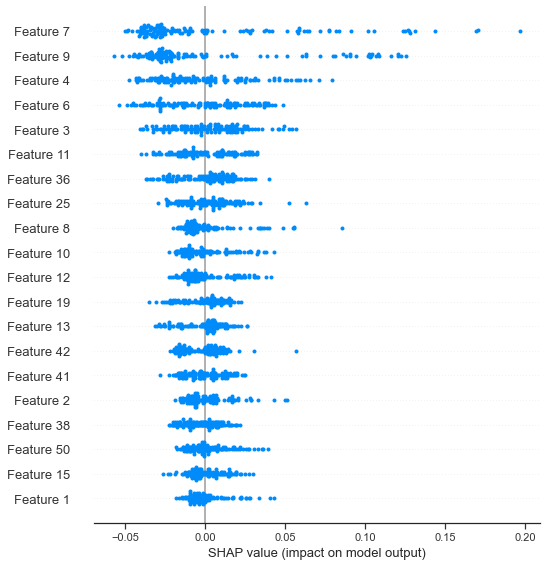

In [332]:
shap.summary_plot(
    predator.shap_feature_selector.shap_values_train_list[3][1],
    # predator.data_materials["Xs_train"][3]
)

In [330]:
predator.data_materials["Xs_train"][3]

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
33,0.3333,0.288192,0.9507,0.943866,1.762130,0.982242,0.020935,2.364912,0.177327,-10.467,...,409.0,399.47700,399.61500,49.6587,49.6587,0.000,0.000,0.000,3.39677,3.57761
163,0.9865,0.987175,0.9910,0.493502,-0.311142,0.127309,0.539862,-0.791911,-1.006540,-1.327,...,185.0,16.45670,16.56390,13.9091,13.9091,662.310,363.355,1025.670,5.32063,5.32063
157,1.0000,0.937500,1.0000,0.968254,0.464410,-0.187766,0.012120,0.768550,-0.689732,-3.785,...,123.0,10.30730,10.30320,16.0023,16.0023,591.640,225.475,817.105,2.87629,2.87629
147,0.3417,0.335476,0.5175,0.460785,0.287548,0.015762,0.391345,1.810031,-0.380573,-2.415,...,243.0,73.34630,73.21840,63.0930,63.0930,0.000,0.000,0.000,3.24571,3.79656
21,1.0000,0.978261,0.9716,0.973020,1.620810,0.273011,0.338102,1.395749,-0.004387,-7.146,...,481.0,153.74700,153.22200,79.5901,79.5901,479.295,324.220,803.525,6.73333,5.58818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.0000,0.640000,1.0000,0.987179,2.224760,-0.018164,0.485696,1.558048,-1.506710,-6.433,...,170.0,1.78315,1.75543,31.0296,31.0296,194.670,160.885,355.555,2.69611,2.69611
55,1.0000,0.229885,0.9861,0.617819,2.309700,-0.027639,-0.156049,-1.830079,-0.807864,-4.039,...,132.0,2.78629,2.83554,26.6826,26.6864,329.955,156.225,486.190,3.82571,3.61298
43,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,-9.979,...,244.0,29.53660,33.85950,21.5088,22.8089,505.680,179.230,684.910,3.20023,2.60679
143,0.2830,0.190818,0.3478,0.339285,-0.088324,0.011974,0.044396,-0.565177,0.904373,-0.333,...,404.0,349.99200,349.31200,85.9637,86.0340,424.660,200.115,624.780,3.91026,3.91026


In [339]:
mean_mean_entries.shape

(131, 10)

In [340]:
predator.data_materials["train_data_processed"][predator.determined_features].shape

(740, 10)

TypeError: '(slice(None, None, None), 9)' is an invalid key

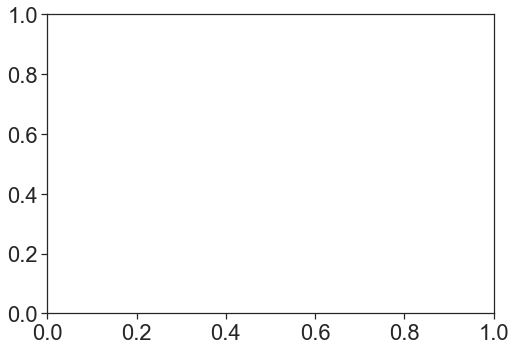

In [338]:
shap.summary_plot(
    mean_mean_entries,
    predator.data_materials["train_data_processed"][predator.determined_features]
)

In [341]:
different_mean = []
for j in range(len(mean_entries)):
    different_mean.append(
        mean_entries[j].mean(axis="rows")
    )

In [342]:
len(different_mean)

733

In [348]:
pd.DataFrame(different_mean)

,9,7,4,3,11,10,12,36,2,22
0,0.000360,0.001220,-0.000757,0.000110,0.000161,-0.000133,0.000198,-0.001067,0.000075,-0.000377
1,0.000404,0.001278,-0.000552,0.000118,0.000181,-0.000266,0.000212,-0.000942,0.000125,-0.000271
2,0.001633,-0.001000,-0.000629,0.000132,0.000157,-0.000903,0.000026,-0.002032,-0.000595,0.001025
3,0.000139,0.002431,0.000028,0.000107,0.000985,-0.000176,0.000235,-0.000871,0.000384,0.000410
4,-0.000097,0.001018,-0.000461,0.000121,-0.000419,0.000401,-0.000263,-0.000543,-0.000212,0.000103
...,...,...,...,...,...,...,...,...,...,...
728,-0.000134,0.001726,-0.001775,-0.000182,0.000151,0.000262,0.000330,-0.001024,0.000269,-0.000516
729,0.000513,0.000864,-0.000577,0.000632,-0.000201,-0.000063,0.000240,-0.002325,0.000260,-0.000054
730,0.000019,0.000097,-0.000122,-0.000275,0.000145,0.000394,0.000179,-0.001104,0.000416,-0.000649
731,-0.000547,0.001119,-0.000433,-0.000348,0.000290,0.000021,0.000345,-0.000998,0.000143,-0.000157


In [343]:
main_data_to_sampled_data_mapping.keys()

dict_keys([0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [347]:
predator.data_materials["train_data_processed"].loc[list(main_data_to_sampled_data_mapping.keys()), predator.determined_features]

,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Solvent_accessibility_wt,Matrix_score,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,solvation_polar_wt
0,-5.895,-0.976256,1.219700,0.968750,87.74030,-3.0,87.44510,-14.8466,1.0000,20.7266
1,-8.175,2.431782,2.076950,0.172500,14.71300,-3.0,17.93570,-21.4288,0.3553,33.7878
2,-7.553,1.956969,2.695710,0.994505,40.99050,-4.0,45.54580,-21.1446,1.0000,23.5257
3,-7.553,1.956969,2.695710,0.973118,40.99050,-4.0,45.54580,-21.1446,1.0000,23.5257
4,-4.158,-0.000303,0.683334,0.222028,47.59930,0.0,51.58730,-18.1753,0.3007,20.9896
...,...,...,...,...,...,...,...,...,...,...
735,-5.785,2.204959,-0.387860,0.306767,2.18605,-1.0,4.81908,-49.8269,1.0000,61.7790
736,-6.559,1.894254,2.178790,0.994505,30.16640,-5.0,30.77380,-21.3820,1.0000,23.1758
737,-6.559,1.894254,2.178790,0.973118,30.16640,-5.0,30.77380,-21.3820,1.0000,23.1758
738,-5.860,0.449541,1.742750,0.517348,30.52460,0.0,29.99560,-23.9552,0.5222,20.1848


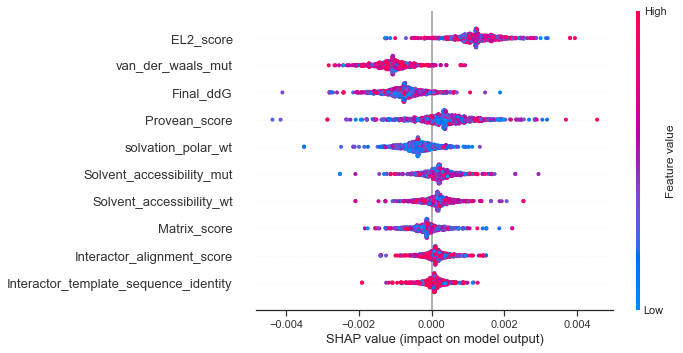

In [354]:
shap.summary_plot(
    np.array(pd.DataFrame(different_mean)),
    predator.data_materials["train_data_processed"].loc[list(main_data_to_sampled_data_mapping.keys()), predator.determined_features]
)

In [352]:
pd.DataFrame(different_mean)

,9,7,4,3,11,10,12,36,2,22
0,0.000360,0.001220,-0.000757,0.000110,0.000161,-0.000133,0.000198,-0.001067,0.000075,-0.000377
1,0.000404,0.001278,-0.000552,0.000118,0.000181,-0.000266,0.000212,-0.000942,0.000125,-0.000271
2,0.001633,-0.001000,-0.000629,0.000132,0.000157,-0.000903,0.000026,-0.002032,-0.000595,0.001025
3,0.000139,0.002431,0.000028,0.000107,0.000985,-0.000176,0.000235,-0.000871,0.000384,0.000410
4,-0.000097,0.001018,-0.000461,0.000121,-0.000419,0.000401,-0.000263,-0.000543,-0.000212,0.000103
...,...,...,...,...,...,...,...,...,...,...
728,-0.000134,0.001726,-0.001775,-0.000182,0.000151,0.000262,0.000330,-0.001024,0.000269,-0.000516
729,0.000513,0.000864,-0.000577,0.000632,-0.000201,-0.000063,0.000240,-0.002325,0.000260,-0.000054
730,0.000019,0.000097,-0.000122,-0.000275,0.000145,0.000394,0.000179,-0.001104,0.000416,-0.000649
731,-0.000547,0.001119,-0.000433,-0.000348,0.000290,0.000021,0.000345,-0.000998,0.000143,-0.000157


In [353]:
predator.data_materials["train_data_processed"].loc[list(main_data_to_sampled_data_mapping.keys()), predator.determined_features]

,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Solvent_accessibility_wt,Matrix_score,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,solvation_polar_wt
0,-5.895,-0.976256,1.219700,0.968750,87.74030,-3.0,87.44510,-14.8466,1.0000,20.7266
1,-8.175,2.431782,2.076950,0.172500,14.71300,-3.0,17.93570,-21.4288,0.3553,33.7878
2,-7.553,1.956969,2.695710,0.994505,40.99050,-4.0,45.54580,-21.1446,1.0000,23.5257
3,-7.553,1.956969,2.695710,0.973118,40.99050,-4.0,45.54580,-21.1446,1.0000,23.5257
4,-4.158,-0.000303,0.683334,0.222028,47.59930,0.0,51.58730,-18.1753,0.3007,20.9896
...,...,...,...,...,...,...,...,...,...,...
735,-5.785,2.204959,-0.387860,0.306767,2.18605,-1.0,4.81908,-49.8269,1.0000,61.7790
736,-6.559,1.894254,2.178790,0.994505,30.16640,-5.0,30.77380,-21.3820,1.0000,23.1758
737,-6.559,1.894254,2.178790,0.973118,30.16640,-5.0,30.77380,-21.3820,1.0000,23.1758
738,-5.860,0.449541,1.742750,0.517348,30.52460,0.0,29.99560,-23.9552,0.5222,20.1848


In [ ]:
shap.summary_plot(predator.shap_feature_selector.shap_values_train_list[3][1],
                  predator.data_materials["Xs_train"][3])

In [350]:
predator.shap_feature_selector.shap_values_train_list[3][1]

array([[ 0.00675143,  0.03406113,  0.00523423, ...,  0.00746138,
        -0.00178211,  0.00535047],
       [ 0.00284846, -0.0026192 , -0.00526738, ...,  0.00369363,
         0.00448079,  0.00321904],
       [ 0.00484521, -0.00480794, -0.01026411, ...,  0.00458182,
         0.00678581,  0.00550819],
       ...,
       [ 0.00125707, -0.00944052,  0.00016517, ..., -0.00094004,
        -0.00062003, -0.00255416],
       [ 0.01572744,  0.02264897,  0.01721051, ...,  0.00171228,
        -0.00045967,  0.00082454],
       [ 0.00125605, -0.00141458,  0.03295801, ...,  0.00389525,
         0.0142879 ,  0.00376068]])

In [351]:
predator.data_materials["Xs_train"][3]

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
33,0.3333,0.288192,0.9507,0.943866,1.762130,0.982242,0.020935,2.364912,0.177327,-10.467,...,409.0,399.47700,399.61500,49.6587,49.6587,0.000,0.000,0.000,3.39677,3.57761
163,0.9865,0.987175,0.9910,0.493502,-0.311142,0.127309,0.539862,-0.791911,-1.006540,-1.327,...,185.0,16.45670,16.56390,13.9091,13.9091,662.310,363.355,1025.670,5.32063,5.32063
157,1.0000,0.937500,1.0000,0.968254,0.464410,-0.187766,0.012120,0.768550,-0.689732,-3.785,...,123.0,10.30730,10.30320,16.0023,16.0023,591.640,225.475,817.105,2.87629,2.87629
147,0.3417,0.335476,0.5175,0.460785,0.287548,0.015762,0.391345,1.810031,-0.380573,-2.415,...,243.0,73.34630,73.21840,63.0930,63.0930,0.000,0.000,0.000,3.24571,3.79656
21,1.0000,0.978261,0.9716,0.973020,1.620810,0.273011,0.338102,1.395749,-0.004387,-7.146,...,481.0,153.74700,153.22200,79.5901,79.5901,479.295,324.220,803.525,6.73333,5.58818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.0000,0.640000,1.0000,0.987179,2.224760,-0.018164,0.485696,1.558048,-1.506710,-6.433,...,170.0,1.78315,1.75543,31.0296,31.0296,194.670,160.885,355.555,2.69611,2.69611
55,1.0000,0.229885,0.9861,0.617819,2.309700,-0.027639,-0.156049,-1.830079,-0.807864,-4.039,...,132.0,2.78629,2.83554,26.6826,26.6864,329.955,156.225,486.190,3.82571,3.61298
43,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,-9.979,...,244.0,29.53660,33.85950,21.5088,22.8089,505.680,179.230,684.910,3.20023,2.60679
143,0.2830,0.190818,0.3478,0.339285,-0.088324,0.011974,0.044396,-0.565177,0.904373,-0.333,...,404.0,349.99200,349.31200,85.9637,86.0340,424.660,200.115,624.780,3.91026,3.91026


In [328]:
predator.determined_features

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Solvent_accessibility_wt',
 'Matrix_score',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'solvation_polar_wt']

In [312]:
print(len(main_data_to_sampled_data_mapping[0]))

foo = 0
for j in range(50):
    foo += pd.DataFrame(predator.shap_feature_selector.shap_values_train_list[j][1]).iloc[:, [9]]

50


In [313]:
foo

,9
0,0.143049
1,0.497900
2,0.087399
3,-0.077831
4,0.336733
...,...
126,0.158846
127,-0.230869
128,-0.329768
129,-0.620195


In [316]:
total

,9,7,4,3,11,10,12,36,2,22
0,0.143049,-0.160287,0.425538,0.561682,0.126812,-0.276206,0.117054,0.055871,0.539136,0.059028
1,0.497900,0.455425,-0.049995,0.270176,0.162679,0.233611,0.073354,0.092895,-0.022757,0.035234
2,0.087399,-0.261411,-0.101471,0.003353,-0.044437,0.031010,-0.083261,-0.053603,0.006120,-0.044167
3,-0.077831,-0.195112,-0.104934,-0.121195,-0.046888,0.079993,0.014262,-0.032683,-0.098907,0.069102
4,0.336733,0.730668,0.199969,0.088093,0.046335,-0.018995,-0.023966,0.016883,0.138851,-0.038819
...,...,...,...,...,...,...,...,...,...,...
126,0.158846,-0.250980,0.449981,0.121491,0.008940,0.218277,-0.019381,0.035907,-0.008593,-0.072852
127,-0.230869,0.206228,-0.251030,0.147242,0.002380,-0.196313,0.056283,-0.122635,-0.058214,-0.063041
128,-0.329768,-0.433488,-0.239773,-0.179870,-0.086947,-0.118705,-0.046975,-0.178953,-0.143023,-0.187812
129,-0.620195,-0.528728,-0.234229,-0.198011,-0.143777,-0.219426,-0.170247,-0.223740,-0.061329,-0.203372


In [ ]:
len(main_data_to_sampled_data_mapping)

In [275]:
main_data_to_sampled_data_mapping[2]

[4, 35]

In [277]:
main_data_to_sampled_data_mapping[544]

[1, 9, 13, 16, 17, 18, 20, 22, 28, 31, 35, 37, 38, 40, 42, 44, 48, 49]

In [294]:
total = 0

In [295]:
A = pd.DataFrame(np.ones((10, 10), dtype=int) * 3)
A

,0,1,2,3,4,5,6,7,8,9
0,3,3,3,3,3,3,3,3,3,3
1,3,3,3,3,3,3,3,3,3,3
2,3,3,3,3,3,3,3,3,3,3
3,3,3,3,3,3,3,3,3,3,3
4,3,3,3,3,3,3,3,3,3,3
5,3,3,3,3,3,3,3,3,3,3
6,3,3,3,3,3,3,3,3,3,3
7,3,3,3,3,3,3,3,3,3,3
8,3,3,3,3,3,3,3,3,3,3
9,3,3,3,3,3,3,3,3,3,3


In [296]:
B = pd.DataFrame(np.ones((10, 10), dtype=int) * 7)
B.iloc[0, 0] = 19
B

,0,1,2,3,4,5,6,7,8,9
0,19,7,7,7,7,7,7,7,7,7
1,7,7,7,7,7,7,7,7,7,7
2,7,7,7,7,7,7,7,7,7,7
3,7,7,7,7,7,7,7,7,7,7
4,7,7,7,7,7,7,7,7,7,7
5,7,7,7,7,7,7,7,7,7,7
6,7,7,7,7,7,7,7,7,7,7
7,7,7,7,7,7,7,7,7,7,7
8,7,7,7,7,7,7,7,7,7,7
9,7,7,7,7,7,7,7,7,7,7


In [297]:
total += A
total += B
total / 2

,0,1,2,3,4,5,6,7,8,9
0,11.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
6,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
7,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
8,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
9,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [298]:
(A + B) / 2

,0,1,2,3,4,5,6,7,8,9
0,11.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
6,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
7,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
8,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
9,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [276]:
predator.shap_feature_selector.shap_values_train_list[4][1]

array([[ 0.0064624 ,  0.00591685,  0.01061839, ...,  0.00053465,
         0.00167579,  0.00055496],
       [-0.00321515, -0.00117757, -0.00672983, ..., -0.00315037,
        -0.00122578, -0.00084323],
       [ 0.00225995, -0.00152647, -0.00299236, ..., -0.00152154,
        -0.00350715, -0.00206054],
       ...,
       [-0.00034525, -0.00105434, -0.01121244, ..., -0.00330553,
        -0.00694493, -0.00493505],
       [-0.00149603, -0.00178549,  0.00444678, ..., -0.00247317,
         0.00209508, -0.00067198],
       [-0.00619485, -0.00158982, -0.01262   , ..., -0.00169417,
        -0.00858945,  0.0011598 ]])

In [273]:
pd.DataFrame(predator.shap_feature_selector.shap_values_train_list[44][1]).iloc[:, col_ix]

,9,7,4,3,11,10,12,36,2,22
0,0.017056,-0.003323,-0.017959,0.049688,0.001023,0.008560,0.003677,0.003741,0.061927,0.001505
1,0.019791,-0.024203,0.035015,0.003296,-0.008712,0.011311,0.001737,0.007297,-0.008117,0.015028
2,0.027761,-0.031167,0.019988,-0.046595,-0.002290,-0.008532,0.004438,-0.011544,-0.009225,-0.006611
3,-0.020649,-0.026613,-0.003336,0.008565,-0.031539,-0.008928,-0.011605,-0.002612,0.034395,0.004595
4,0.003794,-0.027698,-0.026417,0.022311,0.007859,-0.013649,0.010388,-0.007141,0.008477,-0.009886
...,...,...,...,...,...,...,...,...,...,...
126,0.073002,0.041469,0.034495,-0.002465,-0.000623,0.000051,-0.001557,0.007130,0.001533,0.009775
127,-0.036960,-0.025209,-0.029643,-0.030220,-0.012197,-0.006644,-0.004931,-0.002416,-0.019199,-0.000607
128,-0.011773,-0.014072,0.001115,0.028852,-0.000200,-0.002443,-0.005577,-0.023999,-0.021837,-0.010550
129,-0.025867,-0.013867,0.003249,-0.052408,-0.024993,-0.002582,-0.018175,-0.007103,-0.021005,0.002469


In [244]:
predator.data_materials["train_data_processed"].iloc[[7]]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
7,0,O43521-3,G66A,Q07812-5,1.0,0.657143,0.3623,0.161145,1.0328,-0.083838,...,187.0,1.96537,1.97697,225.563,225.563,447.125,288.435,735.565,3.45953,2.63225


In [ ]:
ns = []
for k, v in main_data_to_sampled_data_mapping.items():
    print(f"{k} -> {len(v)}")
    ns.append(len(v))

In [ ]:
ns

In [ ]:
plt.hist(ns, bins=50)
plt.xticks(range(0, 51, 10))
plt.show()


this makes sense because we did not perform a random sampling. It was single protein single mutation sampling.

for example, the protein Q969J2 occurs only once. this implies that each sample data will contain this entry.

In [229]:
predator.data_materials["train_data_processed"].iloc[[16]]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
16,1,Q969J2,G79R,Q96IT1,0.6444,0.614394,0.625,0.55,-0.094158,0.0,...,185.0,20.2257,20.325,12.6355,12.6355,778.23,317.79,1096.02,4.87775,3.8904


In [245]:
predator.data_materials["train_data_processed"]["UniProt_ID"].value_counts()["Q969J2"]
predator.data_materials["train_data_processed"]["UniProt_ID"].value_counts()["O43521-3"]

26

In [193]:
round(df_array[0][8], 4)

1.2197

In [194]:
type(df_array[0][8])

float

In [ ]:
list(zip(*map(df.get, df)))

In [128]:
for index in range(len(predator.data_materials["train_data_processed"])):
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [130]:
predator.data_materials["train_data_processed"].iloc[[88], :]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
88,0,O43521-3,G66E,Q07812-8,1.0,0.714286,0.2695,0.217124,2.63731,0.007238,...,189.0,4.02917,5.46857,49.7783,49.7783,402.525,231.455,633.985,3.4158,1.82025


In [162]:
def is_this_row_occur_here(query_row, recovered_df):
    n_found = 0
    for ix in range(len(recovered_df)):
        if tuple(query_row) == tuple(recovered_df.iloc[ix, :]):
            n_found += 1

    assert n_found in [0, 1], n_found
    return bool(n_found)

In [167]:
def which_sampled_data_had_this_row(query_row, recovered_dfs):
    found_dataframe_nums = []
    for i in range(len(recovered_dfs)):
        if is_this_row_occur_here(
            query_row, recovered_dfs[i]
        ):
            # print(f'found one! i={i}')
            found_dataframe_nums.append(i)

    return found_dataframe_nums

In [169]:
which_sampled_data_had_this_row(
    predator.data_materials["train_data_processed"].iloc[88, :],
    recovered_sampled_datasets
)

[37]

In [170]:
which_sampled_data_had_this_row(
    predator.data_materials["train_data_processed"].iloc[469, :],
    recovered_sampled_datasets
)

[25, 29]

# recovering :(

In [178]:
main_data_to_sampled_data_mapping = {}
for main_i in tqdm(range(len(predator.data_materials["train_data_processed"]))):
    main_data_to_sampled_data_mapping[main_i] = which_sampled_data_had_this_row(
        predator.data_materials["train_data_processed"].iloc[main_i, :],
        recovered_sampled_datasets
    )

  0%|          | 0/740 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [174]:
main_data_to_sampled_data_mapping

{0: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 1: [1,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  18,
  19,
  22,
  23,
  25,
  31,
  32,
  33,
  34,
  35,
  36,
  40,
  41,
  43,
  45,
  46,
  49],
 2: [4, 35],
 3: [10, 46, 48],
 4: [1, 2, 12, 27, 45],
 5: [6, 14, 17, 19],
 6: [],
 7: [40],
 8: [7],
 9: [25],
 10: [8, 39],
 11: [0,
  1,
  2,
  5,
  7,
  8,
  9,
  11,
  14,
  15,
  17,
  19,
  20,
  22,
  23,
  25,
  26,
  27,
  30,
  33,
  34,
  35,
  39,
  40,
  42,
  43,
  48],
 12: [14, 15, 28],
 13: [12, 16, 17, 31, 40, 43, 45],
 14: [4, 23, 44, 46],
 15: [3, 12, 34, 41, 43, 45, 47],
 16: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,

ValueError: x and y must have same first dimension, but have shapes (740,) and (1,)

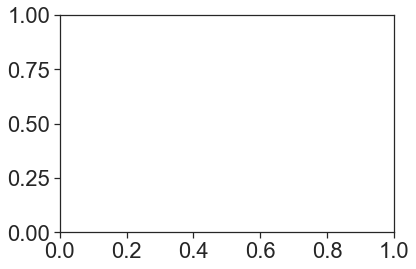

In [ ]:
all(predator.data_materials["train_data_processed"].iloc[88, :] == recovered_sampled_datasets[0].iloc[1, :])

In [131]:
recovered_sampled_datasets[0]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,P84243,Q94A,Q9UER7-3,1.000000,0.948980,1.0000,0.306767,-0.387860,0.995137,...,309.0,21.2713,20.8506,32.48860,32.48860,1159.700,952.745,2112.450,3.00752,4.27950
1,0,P23297,L12H,P25815,0.677800,0.664382,0.5222,0.517348,1.347360,0.389287,...,188.0,26.6920,26.6217,17.20170,17.20170,667.920,288.795,956.720,3.51062,3.45116
2,1,P40692,C77R,P54278,0.333300,0.288192,0.9507,0.943866,1.762130,0.982242,...,409.0,399.4770,399.6150,49.65870,49.65870,0.000,0.000,0.000,3.39677,3.57761
3,0,O14965,G198A,Q9NQS7,0.683200,0.629376,1.0000,0.508475,4.304660,0.987585,...,292.0,80.0940,80.8401,2.20488,2.20488,367.490,187.965,555.455,4.53101,4.05405
4,0,Q71DI3,R64A,P62805,0.991667,0.892083,1.0000,0.891262,1.163450,0.994134,...,222.0,22.6326,22.5082,32.91710,32.91710,1167.280,460.855,1628.150,5.08779,5.08779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0,Q9NQT4,R96Q,Q96B26,0.971600,0.973020,1.0000,0.978261,2.078510,-0.019309,...,481.0,79.7856,79.4248,154.13600,154.16200,479.295,324.220,803.525,3.51586,3.18071
160,0,Q96AX1,K429D,Q9H269-2,0.966300,0.964737,1.0000,0.292308,0.074316,0.515252,...,689.0,155.5450,155.5020,11.63160,11.63160,288.615,244.200,532.815,3.32787,3.32787
161,1,P21912,R177A,P31040,0.992500,0.541198,0.9671,0.968745,1.569280,0.998093,...,741.0,40.5581,40.4738,216.62600,216.62600,409.030,321.460,730.490,3.51280,4.07626
162,0,P42773,F37I,Q00534,0.464500,0.450335,1.0000,0.963333,2.748040,0.046617,...,455.0,53.3824,53.5470,62.19290,62.27400,315.075,253.540,568.615,3.02357,2.36604


In [85]:
X_all = predator.data_materials["train_data_processed"].drop(["Mutation_Effect_Label", "UniProt_ID", "Mutation", "Interactor_UniProt_ID"], axis="columns")
X_all

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,0.032483,-0.976256,-0.085671,-5.895,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,0.272630,2.431782,-0.703858,-8.175,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,0.224558,1.956969,-1.336380,-7.553,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,0.224558,1.956969,-1.336380,-7.553,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,0.849303,-0.000303,-0.321973,-4.158,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1.0000,0.948980,1.0000,0.306767,-0.387860,0.995137,0.594040,2.204959,-0.444294,-5.785,...,309.0,21.27130,20.85060,32.4886,32.4886,1159.700,952.745,2112.450,3.00752,4.27950
736,1.0000,0.360743,1.0000,0.994505,2.178790,0.803401,0.135349,1.894254,-1.336380,-6.559,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
737,1.0000,0.360743,1.0000,0.973118,2.178790,0.803401,0.135349,1.894254,-1.336380,-6.559,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
738,0.6778,0.664382,0.5222,0.517348,1.742750,0.889921,0.458409,0.449541,-1.820240,-5.860,...,188.0,26.74010,27.29430,17.1488,16.8699,667.920,288.795,956.720,3.26388,3.30643


In [88]:
X_all

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,0.032483,-0.976256,-0.085671,-5.895,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,0.272630,2.431782,-0.703858,-8.175,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,0.224558,1.956969,-1.336380,-7.553,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,0.224558,1.956969,-1.336380,-7.553,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,0.849303,-0.000303,-0.321973,-4.158,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1.0000,0.948980,1.0000,0.306767,-0.387860,0.995137,0.594040,2.204959,-0.444294,-5.785,...,309.0,21.27130,20.85060,32.4886,32.4886,1159.700,952.745,2112.450,3.00752,4.27950
736,1.0000,0.360743,1.0000,0.994505,2.178790,0.803401,0.135349,1.894254,-1.336380,-6.559,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
737,1.0000,0.360743,1.0000,0.973118,2.178790,0.803401,0.135349,1.894254,-1.336380,-6.559,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
738,0.6778,0.664382,0.5222,0.517348,1.742750,0.889921,0.458409,0.449541,-1.820240,-5.860,...,188.0,26.74010,27.29430,17.1488,16.8699,667.920,288.795,956.720,3.26388,3.30643


In [155]:
y_all = predator.data_materials["train_data_processed"]["Mutation_Effect_Label"].copy()

In [157]:
model = RandomForestClassifier(random_state=42)
model.fit(X_all, y_all)
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(
    X_all, approximate=False, check_additivity=False
)

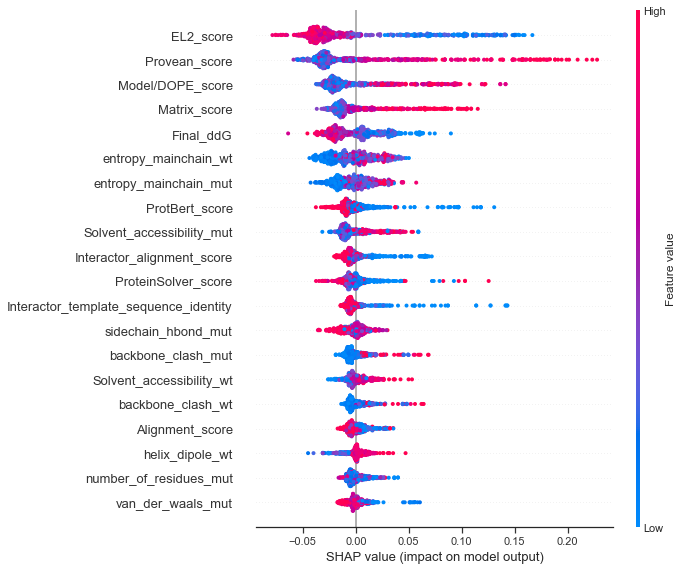

In [159]:
shap.summary_plot(
    shap_values_all[1], X_all
)

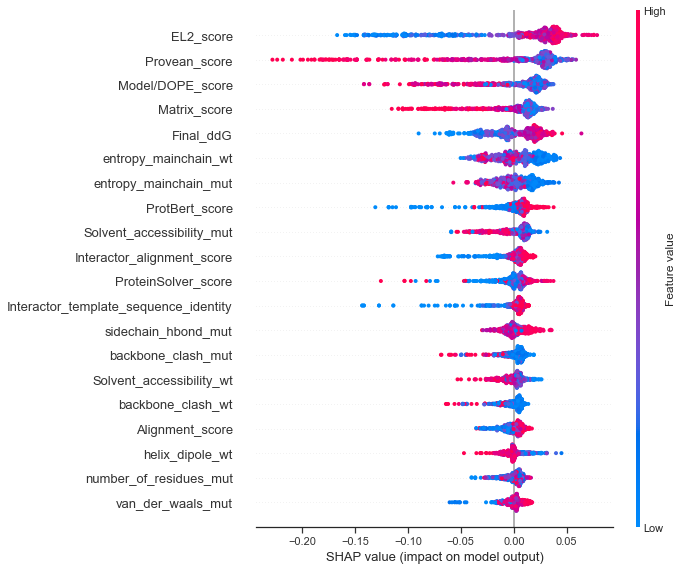

In [160]:
shap.summary_plot(
    shap_values_all[0], X_all
)